In [1]:
import html
import os
import textwrap

import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datasets import load_dataset, load_from_disk
from IPython.display import Markdown, display
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

In [2]:
# Глобальные переменные
rstate = 42

# 1. Подготовка данных и модели

Saving the dataset (0/1 shards):   0%|          | 0/36591 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (2056 > 2048). Running this sequence through the model will result in indexing errors


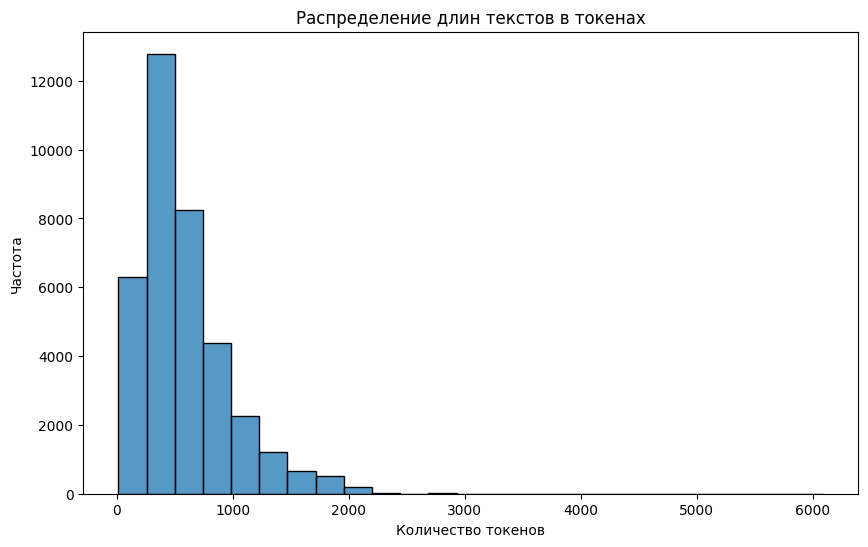

In [3]:
# 1.1. Выбор и загрузка датасета
# Используем датасет с отзывами на фильмы с Кинопоиска
dataset_name = "blinoff/kinopoisk"
local_dataset_path = "./kinopoisk_dataset_local"

# Скачиваем датасет, если локальная копия отсутствует
if os.path.exists(local_dataset_path):
    dataset = load_from_disk(local_dataset_path)
else:
    dataset = load_dataset(dataset_name)
    dataset.save_to_disk(local_dataset_path)

# 1.2. Выбор и загрузка предобученной модели и токенизатора
model_name = "ai-forever/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Добавляем специальный токен для padding, если он отсутствует
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({"pad_token": tokenizer.eos_token})
    model.resize_token_embeddings(len(tokenizer))

# 1.3. Предварительная обработка данных
train_split = dataset["train"]

# Определение оптимальной длины контекста. Посмотрим на распределение длин текстов.
text_lengths = [len(tokenizer.encode(html.unescape(text))) for text in train_split["content"]]
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=25)
plt.title("Распределение длин текстов в токенах")
plt.xlabel("Количество токенов")
plt.ylabel("Частота")
plt.show()

In [4]:
# Исходя из распределения токенов по датасету выберем контекст
# покрывающий больше 50% данных
context_length = 512


# Функция для токенизации
def tokenize_function(examples):
    return tokenizer(
        html.unescape(examples["content"]), padding="max_length", truncation=True, max_length=context_length
    )


# Применяем токенизацию
tokenized_dataset = train_split.map(
    tokenize_function,
    batched=True,
    remove_columns=train_split.column_names,  # Удаляем все старые колонки
)

print("\nСтруктура токенизированного датасета:")
print(tokenized_dataset)

# Создаем train/validation сплит вручную
train_val_split = tokenized_dataset.train_test_split(test_size=0.1, seed=rstate)
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]

print(f"\nРазмер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

# Генератор батчей для обучения
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

Map:   0%|          | 0/36591 [00:00<?, ? examples/s]


Структура токенизированного датасета:
Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 36591
})

Размер обучающей выборки: 32931
Размер валидационной выборки: 3660


## 2. Дообучение модели

### 2.1. Предварительная оценка качества

In [5]:
# Переносим на GPU, если доступно
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Генерируем текст
print("--- Результат генерации ДО дообучения: ---\n")

prompt = "Этот фильм был просто "
print(f"1. Промт: {prompt}\n")
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
output = model.generate(input_ids, max_length=50, num_return_sequences=1, no_repeat_ngram_size=2)
print(tokenizer.decode(output[0], skip_special_tokens=True))

prompt = "2+2+?"
print(f"\n2. Промт: {prompt}\n")
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
output = model.generate(input_ids, max_length=50, num_return_sequences=1, no_repeat_ngram_size=2)
print(tokenizer.decode(output[0], skip_special_tokens=True))

--- Результат генерации ДО дообучения: ---

1. Промт: Этот фильм был просто 

Этот фильм был просто 
&quot;Сумерки&nbsp;Фантазии&raquo; (1968).

В фильме снимались:
-&laquoslash;&mdash;&nbsp;&

2. Промт: 2+2+?

2+2+?

Какие есть способы, чтобы не было проблем с интернетом? Как можно быстрее? Спасибо!
В настройках браузера.
в настройке браузеров
У меня тоже самое, только в настройками брауз


### 2.2. Настройка процесса обучения

In [6]:
# Отключаем внутреннюю многопоточность токенизатора
# Многопоточность будет обеспечена на уровне DataLoader, а не токенизатора.
# Одновременное использование fork (от DataLoader) и threads (от Rust-токенизатора) вызывает deadlocks.
os.environ["TOKENIZERS_PARALLELISM"] = "false"

training_args = TrainingArguments(
    output_dir="./kinopoisk_generator",
    eval_strategy="steps",
    eval_steps=500,
    save_strategy="steps",
    save_steps=1000,
    save_total_limit=3,
    load_best_model_at_end=True,
    learning_rate=2e-5,
    num_train_epochs=5,
    fp16=True,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    dataloader_num_workers=4,
    logging_dir="./logs",
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
    data_collator=data_collator,
)

print("Начинаем дообучение модели...")
trainer.train()
print("Дообучение завершено.")

Начинаем дообучение модели...


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
500,2.882500,2.759239
1000,2.827500,2.721049
1500,2.791200,2.696229
2000,2.773800,2.680707
2500,2.727400,2.670071
3000,2.714000,2.659691
3500,2.707500,2.651815
4000,2.701600,2.643945
4500,2.658600,2.639962
5000,2.662100,2.634457


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Дообучение завершено.


Средняя утилизация GPU по логам `nvidia-smi --query-gpu=timestamp,utilization.gpu --format=csv -l 1 -f "gpu_log.csv"` за все время обучения:

**97.67%**

Оптимизация процесса обучения приемлемая, батчи формируются и подаются оптимально.

In [7]:
# Путь к папке с лучшим чекпоинтом
best_ckpt_path = trainer.state.best_model_checkpoint

# Значение функции потерь на валидационной выборке
best_metric_value = trainer.state.best_metric

print(f"Лучшая модель была загружена из: {best_ckpt_path}")
print(f"Лучший validation loss: {best_metric_value}")

Лучшая модель была загружена из: ./kinopoisk_generator/checkpoint-10000
Лучший validation loss: 2.6127138137817383


### 2.3. Оценка качества обучения

In [8]:
# Используем тот же промпт для сравнения
# trainer.model уже находится на нужном устройстве после обучения
input_ids = tokenizer.encode(prompt, return_tensors="pt").to(trainer.model.device)

# Генерируем текст с помощью дообученной модели
output_after = trainer.model.generate(input_ids, max_length=50, num_return_sequences=1, no_repeat_ngram_size=2)

print("Результат генерации ПОСЛЕ дообучения:")
print(tokenizer.decode(output_after[0], skip_special_tokens=True))

Результат генерации ПОСЛЕ дообучения:
2+2+?

В фильме нет ничего лишнего, все на своем месте.
Сюжет, как и в первой части, не затянут, но всё же не так уж


# 3. Сэмплирование

In [9]:
def run_generation_test(prompt_text, generation_params):
    # Используем устройство, на котором уже лежит модель
    device = trainer.model.device

    # Локальная копия для защиты от изменения глобальной переменной generation_params
    local_params = generation_params.copy()

    # Токенизация промта и передача его на устройство с моделью
    inputs = tokenizer(prompt_text, return_tensors="pt").to(device)

    if "pad_token_id" not in local_params:
        local_params["pad_token_id"] = tokenizer.eos_token_id

    # Запускаем генерацию вывода с ограничем в 400 генерируемых токенов
    output = trainer.model.generate(**inputs, max_new_tokens=400, **local_params)

    # Декодирование выхода модели
    decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)

    # Форматирование вывода для улучшения читаемости в ноутбуке
    decoded_output = html.unescape(decoded_output)
    cleaned_text = " ".join(decoded_output.split())
    wrapped_text = textwrap.fill(cleaned_text, width=100)

    # Вывод параметров и форматированного вывода модели
    title = f"--- ПАРАМЕТРЫ: {local_params} ---"
    markdown_output = f"**{title}**\n\n```\n{wrapped_text}\n```"
    display(Markdown(markdown_output))

In [10]:
sampling_prompt = "Кино вышло что надо. Особенно понравился"

#### 1. Greedy decoding

In [11]:
run_generation_test(sampling_prompt, {"do_sample": False})

**--- ПАРАМЕТРЫ: {'do_sample': False, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился момент с «Пиратами Карибского моря». Сюжет. Сюжет. Сюжет.
Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет.
Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет.
Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет.
```

**Вывод:** ожидаемо генерирует повторяющиеся фразы.

#### 2. Beam search

In [12]:
run_generation_test(sampling_prompt, {"num_beams": 2, "early_stopping": True})
run_generation_test(sampling_prompt, {"num_beams": 5, "early_stopping": True})

**--- ПАРАМЕТРЫ: {'num_beams': 2, 'early_stopping': True, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился момент, когда главный герой говорит, что он — неудачник, а
он — неудачник. Сюжет фильма не вызывает никаких эмоций, но всё же он не такой уж уж и неудачный.
Сюжет не такой уж и плохой, но всё же он не такой уж и плохой. Актёры сыграли хорошо, но всё же не
так как в первой части. Сюжет не такой уж и плохой, но всё же он не такой уж и плохой. Сюжет не
такой уж и плохой, но всё же он не такой уж и плохой. Сюжет не такой уж и плохой, но всё же он не
такой уж и плохой. Сюжет не такой уж и плохой, но всё же он не такой уж и плохой. Сюжет не такой уж
и плохой, но всё же он не такой уж и плохой. Сюжет не такой уж и плохой, но всё же он не такой уж и
плохой. Сюжет не такой уж и плохой, но всё же он не такой уж и плохой. Сюжет не такой уж и плохой,
но всё же он не такой уж и плохой. Сюжет не такой уж и плохой, но всё же
```

**--- ПАРАМЕТРЫ: {'num_beams': 5, 'early_stopping': True, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился эпизод, где главный герой — Брюс Уиллис — попадает в
психиатрическую лечебницу, где он знакомится с женой главного героя — Кейт Уинслет. Сюжет фильма
довольно прост, но в то же время он заставляет задуматься о многих вещах, о жизни, о смысле жизни, о
смысле смерти, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о
смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о
смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о
смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о
смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о
смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о
смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о смысле жизни, о
смысле жизни, о смысле жизни, о
```

**Вывод:** Генерирует связные, но все еще повторяющиеся фразы.

#### 3. Temperature sampling

In [13]:
run_generation_test(sampling_prompt, {"do_sample": True, "temperature": 0.7})
run_generation_test(sampling_prompt, {"do_sample": True, "temperature": 1.2})

**--- ПАРАМЕТРЫ: {'do_sample': True, 'temperature': 0.7, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился момент с поездом и от этого картина показалась более
динамичной. По сюжету, все было так, как и должно быть: на первом месте — любовь к своей сестре, а
на втором месте — месть. Но вскоре к сцене привязывается парень, который убивает не своего брата, а
его сестру. На втором месте любовь и любовь к своему лучшему другу. На финальном месте любовь к
своей жизни. Сцена в концлагере. Да, были слезы и я не хотел, чтобы кто то смотрел на меня и мне
стало стыдно. Это не смешно. Это фильм, который не относится к таким фильмам, как «Спасти рядового
Райана». Это не фильм, который надо смотреть и он не откроет все глубины сюжета. Это это фильм,
который нужно смотреть и он не откроет все глубины. Это фильм, который нужно смотреть и он не
откроет все глубины и глубины. Это не фильм, который надо смотреть и он не откроет все глубины. Это
фильм который нужно смотреть и он не откроет все глубины и глубины. Это фильм, который нужно
смотреть и он не откроет все глубины и глубины. К сожалению, я не понял, что это за фильм и почему я
не понял этого фильма, потому что он не откроет все глубины и глубины. Итог: фильм не отметил ни
одного момента. И это, наверное, главное. В
```

**--- ПАРАМЕТРЫ: {'do_sample': True, 'temperature': 1.2, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился саундтрек главной роли, который напомнил историю про Софи.
Так и хочется вспомнить этот самый саундтрек. Дословно напишу, что секрет всех фильмов «Софи» очень
прост — они все хороши по праву, все хорошее должно быть добрым. Вот этим и прогадили всех плохих
людей нашего городка… Так и получилось. «Рок» не был шедевром. Здесь у них было очень много всего. И
самым главным в них было то, что они прекрасно жили жизнью своих героев, ничего плохого не прошло.
Фильм хорош тем, что построил в нем все проверенные в последних трех фильмах самые лучшие
человеческие образы люди. И герои тоже, все дошли до этого фильма. Главный злодей — каменная
челюсть, она того заслуживает! Очень колоритная и одновременно простая роль. Но в первую очередь,
меня поразили два взлета эмоций после смерти главного героя. Первая причина смерти главного героя —
это то, что... что у самого Кобба в реальности умерла жена. А потом — он влюбился в нее. Теперь
собственно к музыке композитора и аккора Брюстера. Песни, которые вошли в основу фильма в основном и
в основном — сопереживание главного героя, исполняют также замечательно. Кен Вачовски. Я вообще его
долго считала безногим парнем, но появилась одна его работа — «Переменка». Все эти написания можно
перечислять очень долго-больно по многим пунктам... так что все 9 из 10 p.s. «У каждой свое время» К
```

**Вывод**: добавление случайности радикально решило проблему повторяющихся фраз. С увеличением температуры они пропадают вовсе. Но теперь, модель не генериует `EOS` токен, генерация обрывается на пределе генерируемых токенов. 

#### 4. Top-p (nucleus) sampling, Top-k Sampling

In [14]:
run_generation_test(sampling_prompt, {"do_sample": True, "top_p": 0.92, "top_k": 0})
run_generation_test(sampling_prompt, {"do_sample": True, "top_k": 50})

**--- ПАРАМЕТРЫ: {'do_sample': True, 'top_p': 0.92, 'top_k': 0, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился финал «Послезавтрашнего обращения» — и я его пересмотрю!
Клементина как всегда прекрасна. Можно назвать ее нужды не каждому мужчине, а Татьяна играет хорошо.
Аня отлично воплощает загадочную, замкнутую в себе Нину, которая отыскивала способ покарать
преступников, наводить справки о проклятых губернаторах и директоре отеля, описывала все
происходящие действия. Катя — брат Алика. Необычный, чудаковатый, слегка капризный парень. У Эмили
красивые длинные волосы и поросячий хвост, с блеском спускающийся на локоть для улыбок. На природе
часто бывает так, что в утробе женщина выглядит просто как жертва какого-нибудь гада или жениха, а
бывшие супруги добросовестно прясть от женихов и жить дальше. Главное даже не правильно с ними
поступать, не дать испытать боль в самом себе, чтобы продолжать любить любимого человека, который не
такой как она все о себе рассказывает. Саша тоже прекрасный актер, всю свою роль он считает ролью
родителей и это самый яркий ее актер. Мы с товарищем уже давно подумали над Ниной, т. к. начали было
присматриваться к ней всерьез. Ан нет. Со всеми этими ее трижды «Вернитесь назад» она вышла
настоящей леди. Под вечер вы будете вместе с главным героем смотреть игру Алика в колодец, сидя на
стене. Аля все так быстро пыталась объяснить, чтобы никто не ударил в других, и надеялась, что
```

**--- ПАРАМЕТРЫ: {'do_sample': True, 'top_k': 50, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился момент, где Дилип Мерфи(сыну, кстати, понравился) из леса в
свою защиту от врагов бежит к окровавленных людей. Ну что нельзя было все таки пропустить этот
момент? Каков смысл фильма, про который ты не знаешь, в то же время и смотришь его в оригинале. Но
все равно, он сделан очень профессионально и неоднократно превзошел самые смелые ожидания
кинолюбителей. В конце концов, когда ты смотришь фильм, у тебя невольно открываются глаза на
содержание фильма. И что, в чем смысл фильма? Где длинная вереница непонятных персонажей, которые
живут вместе, мучают друг друга, пытаются найти себя? И в конце они не находят. Что… это всего лишь
пустая трата времени. Точнее, в том что фильм построен слишком бездарно, и создатели фильма и его
продюсер хотели просто дать зрителю высказаться, но потом решили, что в каждом найдется и вся
ошибка, ведь все в этом фильме очень красиво и очень правдоподобно, просто посмотрите его и не сразу
задумаетесь почему. Все знают что главный герой — это человек с его недостатками, и найти в нем
недостатки не удалось. Но ведь в «Шоу Трумана», который по моему мнению получился лучше «Пиратов
Карибского моря» будет говорить о том, что все эти недостатки действительно есть. Я буду прав, здесь
это в фильме и правда очень здорово. Единственное, кто мог это сделать, так это «Пинокио» с
прекрасной музыкой. Не могу в конце вспомнить, что
```

**Вывод:** практически получился связный текст. По сути оба метода выбора следующего токена решают одинаковую задачу - выводы очень похожи. 

#### 6. Min-p Sampling

In [15]:
run_generation_test(
    sampling_prompt,
    {
        "do_sample": True,
        "min_p": 0.05,
        "pad_token_id": tokenizer.eos_token_id,
    },
)

**--- ПАРАМЕТРЫ: {'do_sample': True, 'min_p': 0.05, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился финал, который, если честно, мне понравился больше, чем
впервые увиденный. Впечатления от фильма очень противоречивые, как то: как то так: «В этом фильме не
бывает скучно» или «Но ты это знаешь, как было раньше» После просмотра фильма я не заметил каких-
либо событий, которые вызвали у меня такие ощущения, как раз таки потому, что я просто не справился
с поставленным сюжетом. Сюжет — это что-то очень много и довольно интересный, и я ожидал, что вся
эта потряска и погони за реальным, реальным и вместе с тем… Я не понимаю зачем нужно было снимать
подобное? Мне было бы понятно, что эта тема в фильме будет интересна всем, кто смотрел этот фильм, а
не только тем, кто еще не впечатлился после него, и кто уже понял, что такое хорошо и что такое
плохо. А вот как это сделать, я не понимаю, потому что я не знаю, как это все понять. Операторская
работа — это, пожалуй, одно из лучших, что я видел за последнее время в кино, особенно когда снимал
фильм для большинства. И еще одно, что это не фильм, а игра актеров, которых играет какая-то другая
актриса, или просто кто то другой, это я говорю про актеров, а не актеров, которые играют. Игра
актеров просто великолепная. Каждый из них играл по-своему, каждая сцена, каждая шутка, каждая
реплика — это что-
```

### 3.2. Комбинации параметров сэмплирования

#### Комбинация 1: Высокая температура + Top-k

In [16]:
run_generation_test(sampling_prompt, {"do_sample": True, "temperature": 1.2, "top_k": 50})

**--- ПАРАМЕТРЫ: {'do_sample': True, 'temperature': 1.2, 'top_k': 50, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился саундтрофт от «Кокаина» Гая и «Игры разума» — весьма
удачное сочетание. Отдельные «сценки» с экранами. На мой взгляд, это награды по спецэффектам, снятые
на большую мощность и запудренные бюджетами по всем фильмам. Так, к примеру, у фильма «Поймай меня,
если сможешь» и «Я с Земли…» — одно и очень высокое число. Очень хорошо вписались в экран, в какой-
либо момент можно увидеть, что на их место уже ставили компьютерные эффекты снятые за пределами того
же «Кокаина». Например, сцена с пистолетом «Трафик» в море. Что нужно, например при видео качестве
ниже не бывает. Поэтому не стоит обвинять Гая Ричи в своей гениальной работе, ведь за «Прыжку в
Сетунь» можно поставить гораздо меньшую ставшую чем было бы наоборот оценку. Это же «Год Х». В том
числе к тому же, он не «Сонной Лощины». В конкретных отношениях, все прекрасно. Музыка, работа
режиссера, сценарий, монтаж. Фильм, конечно, имеет свое место в том же мире, что и все другие его
работы. К месту и как бы ни казалось странным, что созданные им фильмы выходят такими качественными,
и не вызывают у человека чувство зависти или наоборот чего-то вроде, восхищения. Этот фильм просто
великолепное сочетание жанров кино, снятого для особого применения. Я никогда не было сомнений, что
фильм
```

**Вывод**: ожидался, креативный разнообразный текст с высокой связностью. Ожидание оправдалось.

#### Комбинация 2: Низкая температура + Top-p (Nucleus)
Идея: сгенерировать очень сфокусированный и предсказуемый текст. Низкая температура делает вероятности более 'острыми', а top-p отсекает маловероятные токены, что усиливает эффект.

In [17]:
run_generation_test(sampling_prompt, {"do_sample": True, "temperature": 0.7, "top_p": 0.9})

**--- ПАРАМЕТРЫ: {'do_sample': True, 'temperature': 0.7, 'top_p': 0.9, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился финал. Фильм действительно хорош. В первую очередь хочу
сказать о сюжете. Он просто великолепен. Но в фильме есть одна маленькая деталь — в конце фильма он
пропадает. А ведь было так недавно. И ведь он застрял в каком-то месте. И мне как актрисе было
понятно, что он не всегда вернется. Но это и неудивительно. Я вообще очень люблю фильмы про любовь.
И в этом фильме она была очень сильной. Не говоря уже о сценах, где героиня фильма сидела в тюрьме.
Во-вторых, это музыка. Музыка действительно великолепна. Она очень подходит фильму. В-третьих, это
актеры. Очень хорошо подобраны актеры. Все актеры очень хорошо сыграли свои роли. Все сыграли
хорошо. В-четвертых, это операторская работа. Все актеры постарались на славу. Особенно хочу
отметить оператора, который снимал фильм в стиле 60-х годов. Он смотрелся очень хорошо. В-пятых, это
музыка. Она просто потрясающая. В-шестых, это спецэффекты. В фильме их так много, что не каждый
может их заметить. В-шестых, это работа операторов. Они работали просто великолепно. В-седьмых, это
режиссерская работа. Все актеры очень хорошо сыграли свои роли. В-девятых, это сюжет. Он очень
хорошо подходит фильму. Итог. Фильм просто великолепен. Я считаю
```

**Вывод**: ожидался, текст с меньшей креативностью по сравнению с предыдущим. Ожидание оправдалось.

#### Комбинация 3: Beam Search + Запрет повторов n-грамм
Идея: получить гладкий и связный текст (за счет `num_beams`), но принудительно запретить модели повторять одни и те же пары слов (`no_repeat_ngram_size=2`). Это часто спасает от зацикливаний.

In [18]:
run_generation_test(sampling_prompt, {"num_beams": 5, "no_repeat_ngram_size": 2, "early_stopping": True})

**--- ПАРАМЕТРЫ: {'num_beams': 5, 'no_repeat_ngram_size': 2, 'early_stopping': True, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился момент, когда главный герой в исполнении Леонардо Ди Каприо
(Кевин Спейси) — это не просто герой, а настоящий герой. Сюжет: Фильм основан на реальных событиях,
произошедших с Джеком Воробьём и его друзьями. В фильме рассказывается о том, что жизнь человека
зависит от того, как он относится к жизни других людей. Джек Воробей, человек, который живёт по
законам, которые диктует ему судьба. И в этом мире он не может быть одиноким, ведь у него нет
друзей. Он может быть счастлив, но у него есть только один друг. Но как бы то ни было, Джек всё
равно должен найти своего друга. Ведь это самый верный друг, которого можно найти. А что если он,
вдруг, исчезнет из этой жизни? Что же тогда будет? Ведь Джек такой же человек, каким его
представляют окружающие, и, наверное, именно поэтому, ему, так хочется найти того, кто запомнится
ему. В общем, фильм очень динамичный, интересный, смешной, захватывающий. Актёрский состав подобран
очень хорошо, все актёры справились со своими ролями. Джонни Депп отлично исполнил роль Джека
Воробья. Его персонаж получился очень харизматичным, интересным, запоминающимся. Остальные актёры
тоже порадовали. Они сыграли свои роли очень убедительно, особенно запомнились: Джоди Фостер, Майкл
Кейн, Том Хэнкс, Эллен Пейдж, Рэйчел МакАдамс, Кира Найтли, Киллиан Мёрфи. Ну и конечно, конечно же,
Хилари Суонк. Её образ
```

**Вывод:** только за счет запрета повторов ожидалось получить связный текст. Ожидание оправдалось. Но повторений все равно очень много, теперь они просто составлены из синонимов.

#### Комбинация 4: Top-k + Top-p
Идея: использовать оба метода фильтрации. Сначала отбираются `k` самых вероятных токенов, а затем из них выбираются те, что попадают в `p` вероятностной массы. Это дает очень сбалансированный и качественный результат.

In [19]:
run_generation_test(sampling_prompt, {"do_sample": True, "top_k": 50, "top_p": 0.92})

**--- ПАРАМЕТРЫ: {'do_sample': True, 'top_k': 50, 'top_p': 0.92, 'pad_token_id': 2} ---**

```
Кино вышло что надо. Особенно понравился эпизод, когда Нэнни и Элайджа Вуд знакомятся с женой. Они
разбиваются на две половинки, что прямо не могло не вызывать симпатии, они видят друг друга в
одиночестве, а когда в качестве любовных приключений и любви всё становится более-менее, они
взаимопонимают. Фильм очень смешной и смешной, причём довольно не забытый, как мне показалось. Когда
я видел его в кинотеатре, я только-только открыл для себя это кино. Я бы сказал, что это именно один
из моих любимых фильмов. Я никогда не буду пересматривать этот фильм, я его ещё не видел в первый
раз. Это кино я пересматривал много раз. Я не буду много говорить, но самое главное, это то, что мои
слова — это главное. Я всегда говорил, что кино должно быть не только смешным, но и грустным. Сам
фильм очень хорошо раскрылся в моей голове после первого просмотра, но этот фильм я бы назвал
немного иначе, ибо он — первый, который я бы назвал «Финал». Если бы я не был так уверен, что первый
раз я увидел трейлер к этому фильму, я бы не был бы точно уверен в правильности его смысла. Поэтому,
я поставлю ему «Аплодисменты». Я поставил фильму: 10 из 10 Я поставил фильму: 10 из 10 10 из 10 P.S.
А я так не думал,
```

**Вывод:** ожидалось получить золотую середину из методов фильтрации. Текст получился очень связный, но креативность пострадала.

#### EXTRA:

In [20]:
extra_prompt = "2+2=?"
run_generation_test(extra_prompt, {"do_sample": False})

**--- ПАРАМЕТРЫ: {'do_sample': False, 'pad_token_id': 2} ---**

```
2+2=? В фильме «Список Шиндлера» я не увидел ничего особенного. Да и вообще, я не понял, зачем он
снимал этот фильм. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет.
Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет.
Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет. Сюжет.
```

**Оценка:** модель ожидаемо пытается превратить любой текст в отзыв.

In [23]:
extra_prompt = (
    "Скалярная величина, которая характеризует ориентированное «растяжение» или «сжатие» многомерного евклидова"
)
run_generation_test(extra_prompt, {"do_sample": False})

**--- ПАРАМЕТРЫ: {'do_sample': False, 'pad_token_id': 2} ---**

```
Скалярная величина, которая характеризует ориентированное «растяжение» или «сжатие» многомерного
евклидова пространства. Сценарий, как и в первой части, не является «сверхъестественным» или
«непосредственным» действием, а в «сверхъестественном» — это «сверхъестественное» действие, которое
не может быть «сверхъестественным» действием. В фильме «Скала» нет ни одного лишнего слова, ни
одного лишнего момента, ни одной лишней сцены. Сценарий, как и в первой части, не является
«сверхъестественным» действием, а в «сверхъестественном» — это «сверхъестественное» действие,
которое не может быть «сверхъестественным» действием. В фильме «Скала» нет ни одного лишнего слова,
ни одного лишнего слова. Сценарий, как и в первой части, не является «сверхъестественным» действием,
а в «сверхъестественном» — это «сверхъестественное» действие, которое не может быть
«сверхъестественным» действием. Сценарий, как и в первой части, не является «сверхъестественным»
действием, а является «сверхъестественным» действием, которое не может быть «сверхъестественным»
действием. Сценарий, как и в первой части, не является «сверхъестественным» действием, а является
«сверхъестественным» действием, которое не является «сверхъестественным» действием. Сценарий, как и
в первой части, не является «сверхъестественным» действием, а является «сверхъестественным»
действием, которое не является «сверхъестественным» действием.
```

**Оценка:** интересно, что модель продемонстрировала высокую локальную связность генерируемого текста и верно завершила определение детерминанта. Но глобальный текст все равно превращается в отзыв к фильму.

In [22]:
extra_prompt = "swMg6H?7djFR}#mw~~vi|oOJ6h%)qfcEGZdq^s5dLD4f^Gh"
run_generation_test(extra_prompt, {"do_sample": False})

**--- ПАРАМЕТРЫ: {'do_sample': False, 'pad_token_id': 2} ---**

```
swMg6H?7djFR}#mw~~vi|oOJ6h%)qfcEGZdq^s5dLD4f^Ghw Сюжет фильма — это нечто, что можно назвать
«сладким» или «сладким». Это нечто, что можно назвать «сладким» или «сладким». Это нечто, что можно
назвать «сладким». Это нечто, что можно назвать «сладким». Это нечто, что можно назвать «сладким».
Это нечто, что можно назвать «сладким». Это нечто, что можно назвать «сладким». Это нечто, что можно
назвать «сладким». Это нечто, что можно назвать «сладким». Это нечто, что можно назвать «сладким».
Это нечто, что можно назвать «сладким». Это нечто, что можно назвать «сладким». Это нечто, что можно
назвать «сладким». Это нечто, что можно назвать «сладким». Это нечто, что можно назвать «сладким».
Это нечто, что можно назвать «сладким». Это нечто, что можно назвать «сладким». Это нечто, что можно
назвать «сладким». Это нечто, что можно назвать «сладким». Это нечто, что можно назвать «сладким».
Это нечто, что можно назвать «сладким». Это нечто, что можно назвать «сладким». Это нечто, что можно
назвать «сладким». Это нечто, что можно назвать «сладким». Это нечто, что можно назвать «сладким».
Это нечто, что можно назвать «сладким». Это нечто, что можно назвать «с
```

**Оценка:** ожидаемо, garbage in - garbage out.

## 3.2. Анализ результатов и выводы

В работе использовалась модель `rugpt3small` (125M параметров) для дообучения на датасете отзывов Кинопоиска. Датасет состоит из реального пользовательского контента (UGC)с грамматическими ошибками, сленгом и часто лишен строгой логической последовательности.

**Основные наблюдения:**
1.  **Проблема повторов:** Модель склонна к сильному зацикливанию. Базовые методы сэмплирования приводят к бесконечному повторению.
2.  **Влияние температуры:**
    * Высокая температура (> 1.0) делает генерацию излишне хаотичной и нарушает синтаксис.
    * Низкая температура (< 0.8) стабилизирует структуру предложений, но резко повышает вероятность сваливания в циклы без использования штрафов за повторы.
3.  **Аретефакты генерации**: практически полностью отсутствуют. 
4.  **Лучшая стратегия:**
    Наиболее связный результат показала **Комбинация №3: Beam Search + No Repeat N-gram Size**. Этот метод устранил дословные повторы, однако ярко проявилась проблема семантических повторов: модель выражает одну и ту же мысль разными словами.

**Итог:**

Дообученная модель данного размера успешно решает задачу **локальной связности** (построение грамматически верных предложений в стилистике отзывов). Однако задача **глобальной связности** (удержание контекста на протяжении всего текста) для нее слишком сложна — предложения часто не связаны друг с другом логически.

Также после дообучения ярко проявился эффект **катастрофического забывания**: модель настолько сильно адаптировалась к домену отзывов, что потеряла способность адекватно генерировать тексты других жанров, отвечая на любые запросы либо в стиле рецензии, либо случайным шумом.